# Setup

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import nltk
from nltk.corpus import stopwords
from tqdm import trange
from collections import Counter
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm
from sklearn import svm

In [2]:
df = pd.read_csv('https://github.com/Adkurrr/Sentiment-Analysis-with-Aspect-Based-Approach-on-Spotify-App-with-SVM/blob/main/Dataset/reviews.csv?raw=true', delimiter=',')
df.head()

,Time_submitted,Review,Rating,Total_thumbsup,Reply
0,2022-07-09 15:00:00,"Great music service, the audio is high quality...",5,2,NaN
1,2022-07-09 14:21:22,Please ignore previous negative rating. This a...,5,1,NaN
2,2022-07-09 13:27:32,"This pop-up ""Get the best Spotify experience o...",4,0,NaN
3,2022-07-09 13:26:45,Really buggy and terrible to use as of recently,1,1,NaN
4,2022-07-09 13:20:49,Dear Spotify why do I get songs that I didn't ...,1,1,NaN


# Praproses Data

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61594 entries, 0 to 61593
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Time_submitted  61594 non-null  object
 1   Review          61594 non-null  object
 2   Rating          61594 non-null  int64 
 3   Total_thumbsup  61594 non-null  int64 
 4   Reply           216 non-null    object
dtypes: int64(2), object(3)
memory usage: 2.3+ MB


### Handling missing value

In [4]:
df.isnull().sum()

Time_submitted        0
Review                0
Rating                0
Total_thumbsup        0
Reply             61378
dtype: int64

In [5]:
df.drop('Reply', axis=1, inplace=True)

### Handing duplicated data

In [6]:
df.duplicated().sum()

0

### Lowercase, clear stop words and clear punctuations

In [7]:
# nltk.download('stopwords')

In [ ]:
def clean(review):
    review = review.lower()
    review = re.sub('[^a-z A-Z 0-9-]+', '', review)
    review = " ".join([word for word in review.split() if word not in stopwords.words('english')])

    return review

In [10]:
df.drop('Time_submitted', axis=1, inplace=True)
df.drop('Total_thumbsup', axis=1, inplace=True)

# Exploratory Data Analysis

### Visualisasi jumlah rating positif, negatif dan netral

In [10]:
df['Rating'].value_counts()

Rating
5    22095
1    17653
4     7842
2     7118
3     6886
Name: count, dtype: int64

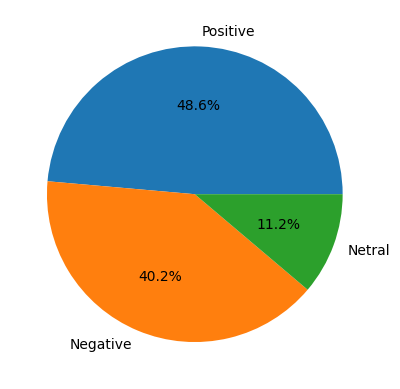

In [11]:
def ratings(rating):
    if rating>3 and rating<=5:
        return "Positive"
    elif rating>0 and rating<3:
        return "Negative"
    else:
        return "Netral"

df['Rating'] = df['Rating'].apply(ratings)
plt.pie(df['Rating'].value_counts(), labels=df['Rating'].unique().tolist(), autopct='%1.1f%%')
plt.show()

### mencari kata paling sering muncul

In [12]:
def corpus(text):
    text_list = text.split()
    return text_list

df['Review_lists'] = df['Review'].apply(corpus)
corpus = []
for i in trange(df.shape[0], ncols=150, nrows=10, colour='green', smoothing=0.8):
    corpus += df['Review_lists'][i]
len(corpus)

mostCommon = Counter(corpus).most_common(10)
mostCommon

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 61594/61594 [00:00<00:00, 109872.31it/s]


[('app', 35591),
 ('music', 25433),
 ('spotify', 18771),
 ('songs', 18217),
 ('song', 14672),
 ('play', 11308),
 ('like', 9760),
 ('listen', 9325),
 ('cant', 9103),
 ('love', 8975)]

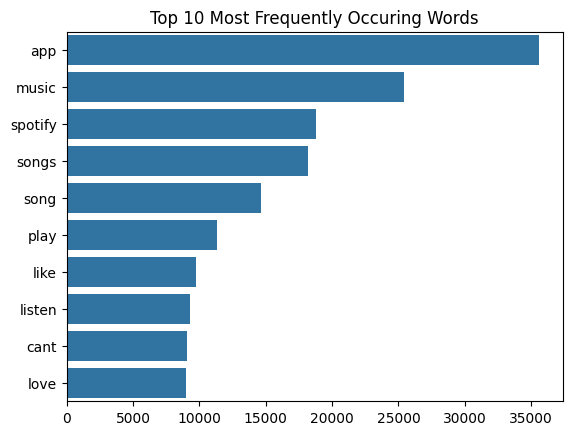

In [13]:
words = []
freq = []
for word, count in mostCommon:
    words.append(word)
    freq.append(count)

sns.barplot(x=freq, y=words)
plt.title('Top 10 Most Frequently Occuring Words')
plt.show()

### WordCloud

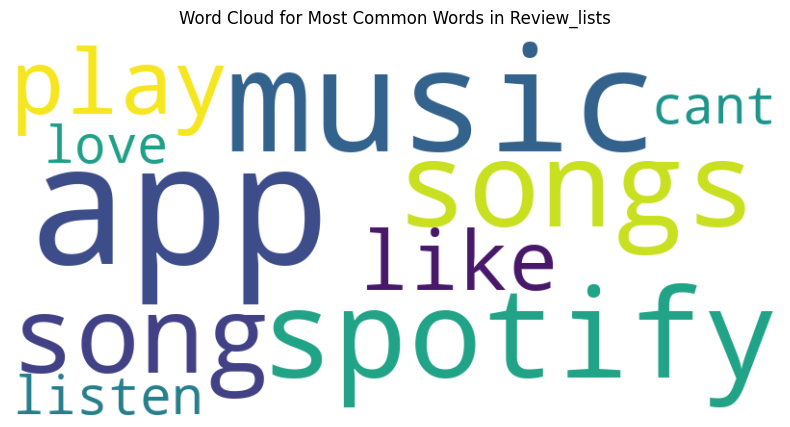

In [14]:
from wordcloud import WordCloud

word_freq_dict = dict(mostCommon)
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq_dict)


plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud for Most Common Words in Review_lists')
plt.axis('off')
plt.show()

# Model

### Sentimen analisis dengan NLTK

In [15]:
# nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [11]:
#download dahulu vander_lexicon jika terjadi error
sia = SentimentIntensityAnalyzer()
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    reviews = row['Review']
    num = i
    res[num] = sia.polarity_scores(reviews)

  0%|          | 0/61594 [00:00<?, ?it/s]

In [12]:
# Membuat DataFrame baru dari hasil analisis sentimen
sentiment_df = pd.DataFrame(res).T

# Membuat fungsi untuk mengklasifikasikan sentimen
def classify_sentiment(score):
    if score >= 0.05:
        return 'positive'
    elif score <= -0.05:
        return 'negative'
    else:
        return 'neutral'

# Mengubah skor sentimen menjadi kategori
sentiment_df['sentiment_category'] = sentiment_df['compound'].apply(classify_sentiment)

# Gabungkan DataFrame sentimen dengan DataFrame awal berdasarkan indeks
df = df.join(sentiment_df[['sentiment_category']])

# Menampilkan DataFrame hasil
print(df.head)

<bound method NDFrame.head of                                                   Review  Rating  \
0      great music service audio high quality app eas...       5   
1      please ignore previous negative rating app sup...       5   
2      pop-up get best spotify experience android 12 ...       4   
3                     really buggy terrible use recently       1   
4      dear spotify get songs didnt put playlist shuf...       1   
...                                                  ...     ...   
61589  even though communicated lyrics feature availa...       1   
61590  use sooo good back downloaded free version cou...       1   
61591  app would good taking device start comp theres...       2   
61592  app good hard navigate wont let play song clic...       2   
61593  good sometimes doesnt load music plays like 8 ...       4   

      sentiment_category  
0               positive  
1               positive  
2               positive  
3               negative  
4               po

# Model

### Split data

In [17]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import tree, metrics
from sklearn.metrics import classification_report

import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.tokenize import TweetTokenizer

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score, f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix, roc_auc_score, recall_score, precision_score

In [16]:
train, test = train_test_split(df, test_size=0.2, random_state=1)
X_train = train['Review'].values
X_test = test['Review'].values
y_train = train['sentiment_category']
y_test = test['sentiment_category']

In [20]:
from nltk.tokenize import word_tokenize
nltk.download('punkt')
def tokenize(text):
    tokens = word_tokenize(text)
    return tokens


from nltk.stem import PorterStemmer
stemmer = PorterStemmer()
def stem_text(text):
    # Tokenisasi kata
    tokens = word_tokenize(text)
    # Melakukan stemming untuk setiap kata dalam teks
    stemmed_text = [stemmer.stem(word) for word in tokens]
    return stemmed_text

en_stopwords = set(stopwords.words("english"))

# vectorizer = CountVectorizer(
#     analyzer = 'word',
#     tokenizer = tokenize,
#     lowercase = True,
#     ngram_range=(1, 1),
#     stop_words = en_stopwords)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [24]:
# kfolds = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

In [ ]:
# np.random.seed(1)

# pipeline_svm = make_pipeline(vectorizer,
#                             SVC(probability=True, kernel="linear", class_weight="balanced"))

# grid_svm = GridSearchCV(pipeline_svm,
#                     param_grid = {'svc__C': [0.01, 0.1, 1]},
#                     cv = kfolds,
#                     scoring="roc_auc",
#                     verbose=1,
#                     n_jobs=-1)

# grid_svm.fit(X_train, y_train)
# grid_svm.score(X_test, y_test)

In [22]:
def report_results(model, X, y):
    pred_proba = model.predict_proba(X)[:, 1]
    pred = model.predict(X)

    auc = roc_auc_score(y, pred_proba)
    acc = accuracy_score(y, pred)
    f1 = f1_score(y, pred)
    prec = precision_score(y, pred)
    rec = recall_score(y, pred)
    result = {'auc': auc, 'f1': f1, 'acc': acc, 'precision': prec, 'recall': rec}
    return result

In [ ]:
report_results(grid_svm.best_estimator_, X_test, y_test)

In [29]:
# Define the vectorizer with correct stop_words parameter
vectorizer = CountVectorizer(stop_words='english')  # or provide a valid list of stop words

# Create the SVM pipeline
pipeline_svm = make_pipeline(vectorizer,
                             SVC(probability=True, kernel="linear", class_weight="balanced"))

# Define kfolds (assuming k=5, adjust as needed)
kfolds = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

# Set up GridSearchCV
grid_svm = GridSearchCV(pipeline_svm,
                        param_grid={'svc__C': [0.01, 0.1, 1]},
                        cv=kfolds,
                        scoring="roc_auc",
                        verbose=1,
                        n_jobs=-1)

# Fit the model
grid_svm.fit(X_train, y_train)

# Score the model
score = grid_svm.score(X_test, y_test)
print(f"Test ROC AUC score: {score}")

Fitting 5 folds for each of 3 candidates, totalling 15 fits


KeyboardInterrupt: 

In [ ]:
nltk.download('punkt')
# Ensure there are no missing values in the columns of interest
df.dropna(subset=['review', 'sentiment_category'], inplace=True)

# Convert sentiment_category to numerical labels
df['sentiment_category'] = df['sentiment_category'].map({'positive': 1, 'neutral': 0, 'negative': -1})

# Split the data into training and testing sets
X = df['review']
y = df['sentiment_category']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Define the vectorizer and SVM pipeline
vectorizer = TfidfVectorizer(stop_words='english', tokenizer=nltk.word_tokenize)
pipeline = Pipeline([
    ('vectorizer', vectorizer),
    ('svm', SVC(probability=True, kernel='linear', class_weight='balanced'))
])

# Define the parameter grid for GridSearchCV
param_grid = {
    'svm__C': [0.01, 0.1, 1, 10]
}

# Define the cross-validation strategy
kfolds = KFold(n_splits=5, shuffle=True, random_state=42)

# Set up GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, cv=kfolds, scoring='accuracy', verbose=1, n_jobs=-1)

# Fit the model
grid_search.fit(X_train, y_train)

# Make predictions
y_pred = grid_search.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')
print('Classification Report:')
print(classification_report(y_test, y_pred, target_names=['negative', 'neutral', 'positive']))

# Print the best parameters
print(f'Best parameters: {grid_search.best_params_}')